### Import Modules

In [ ]:
!pip install yt-dlp opencv-python imageio transformers torch moviepy openai-whisper deep-translator
!pip install chromadb sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 26.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 M

In [ ]:
import os
import cv2
import json
import yt_dlp
import imageio.v2 as imageio
import whisper
import moviepy.editor as mp
from transformers import BlipProcessor, BlipForConditionalGeneration
import json
import chromadb
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator

  if event.key is 'enter':



In [ ]:
# ---------------- FOLDERS ----------------
VIDEOS_FOLDER = "/content/videos"
KEYFRAMES_FOLDER = "/content/keyframes"
TRANSCRIPT_FOLDER = "/content/transcripts"
os.makedirs(VIDEOS_FOLDER, exist_ok=True)
os.makedirs(KEYFRAMES_FOLDER, exist_ok=True)
os.makedirs(TRANSCRIPT_FOLDER, exist_ok=True)

### Extracting transcript, keyframes (and descriptions), metadata from videos

##### Functions to handle data processing tasks

In [ ]:
# ---------------- LOAD MODELS ----------------
# ASR Model for generating transcripts with timestamps
whisper_model = whisper.load_model("medium")

# Image Captioning for keyframe descriptions
# using lightweight model for faster infernece, can use 'Salesforce/blip-image-captioning-large' for more detailed descriptions
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

100%|█████████████████████████████████████| 1.42G/1.42G [00:44<00:00, 34.6MiB/s]
  checkpoint = torch.load(fp, map_location=device)

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [ ]:
# download videos from YouTube along with metadata
def download_videos(video_urls):
    ydl_opts = {
        'format': 'best',
        'outtmpl': f"{VIDEOS_FOLDER}/%(title)s.%(ext)s",
        'writeinfojson': True,
        'postprocessors': [{
            'key': 'FFmpegMetadata'
        }]
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download(video_urls)

In [ ]:
#  extracts video metadata: Title, Description, UR
def extract_metadata(video_path):
    json_metadata_path = video_path.replace(".mp4", ".info.json")

    if os.path.exists(json_metadata_path):
        with open(json_metadata_path, "r") as f:
            metadata_json = json.load(f)

        return {
            "Title": metadata_json.get("title", "Unknown"),
            "Description": metadata_json.get("description", "No description available."),
            "Duration": metadata_json.get("duration", "Unknown"),
            "Resolution": f"{metadata_json.get('width', '?')}x{metadata_json.get('height', '?')}",
            "FPS": metadata_json.get("fps", "Unknown"),
            "URI": metadata_json.get("webpage_url", video_path)
        }
    else:
        return {
            "Title": os.path.basename(video_path),
            "Description": "No description available.",
            "Duration": "Unknown",
            "Resolution": "Unknown",
            "FPS": "Unknown",
            "URI": video_path
        }

In [ ]:
# extracts keyframes from a video every 5 seconds
def extract_keyframes(video_path, output_folder, interval=5):
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    keyframes_dir = os.path.join(output_folder, video_name)
    os.makedirs(keyframes_dir, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count // fps

    keyframes = []
    for sec in range(0, duration, interval):
        cap.set(cv2.CAP_PROP_POS_FRAMES, sec * fps)
        success, frame = cap.read()
        if success:
            frame_path = os.path.join(keyframes_dir, f"frame_{sec}.jpg")
            cv2.imwrite(frame_path, frame)
            keyframes.append(frame_path)
    cap.release()

    return keyframes

In [ ]:
# generates a scene description for an image
def generate_caption(image_path):
    image = imageio.imread(image_path)
    inputs = processor(images=image, return_tensors="pt")
    output = blip_model.generate(**inputs)
    return processor.decode(output[0], skip_special_tokens=True)

In [ ]:
# extracts transcript in hindi and converts it to english using Whisper and google translate
def extract_transcript(video_path):
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    transcript_path = os.path.join(TRANSCRIPT_FOLDER, f"{video_name}.json")

    audio = mp.VideoFileClip(video_path).audio
    audio_path = f"/content/{video_name}.mp3"
    audio.write_audiofile(audio_path, codec="mp3")

    result = whisper_model.transcribe(audio_path, language="hi")
    transcript_data = []
    for segment in result["segments"]:
        translated_text = GoogleTranslator(source="hi", target="en").translate(segment["text"])
        transcript_data.append({
            "start_time": segment["start"],
            "end_time": segment["end"],
            "text": translated_text
        })

    with open(transcript_path, "w") as f:
        json.dump(transcript_data, f, indent=4)

    return transcript_path, transcript_data

##### Process all videos

In [ ]:
video_urls = [
    "https://www.youtube.com/watch?v=ftDsSB3F5kg",
    "https://www.youtube.com/watch?v=kKFrbhZGNNI",
    "https://www.youtube.com/watch?v=6qUxwZcTXHY",
    "https://www.youtube.com/watch?v=MspNdsh0QcM",
    "https://www.youtube.com/watch?v=Kf57KGwKa0w"
]

In [ ]:
print("Downloading Videos...")
download_videos(video_urls)

[youtube] Extracting URL: https://www.youtube.com/watch?v=ftDsSB3F5kg
[youtube] ftDsSB3F5kg: Downloading webpage
[youtube] ftDsSB3F5kg: Downloading tv client config
[youtube] ftDsSB3F5kg: Downloading player e7567ecf
[youtube] ftDsSB3F5kg: Downloading tv player API JSON
[youtube] ftDsSB3F5kg: Downloading ios player API JSON


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

[youtube] ftDsSB3F5kg: Downloading m3u8 information
[info] ftDsSB3F5kg: Downloading 1 format(s): 18
[info] Writing video metadata as JSON to: /content/videos/निर्देशक की भूमिका भाग - 1.info.json
[download] Destination: /content/videos/निर्देशक की भूमिका भाग - 1.mp4
[download] 100% of   11.85MiB in 00:00:00 at 20.12MiB/s  
[Metadata] Adding metadata to "/content/videos/निर्देशक की भूमिका भाग - 1.mp4"
[youtube] Extracting URL: https://www.youtube.com/watch?v=kKFrbhZGNNI
[youtube] kKFrbhZGNNI: Downloading webpage
[youtube] kKFrbhZGNNI: Downloading tv client config
[youtube] kKFrbhZGNNI: Downloading tv player API JSON
[youtube] kKFrbhZGNNI: Downloading ios player API JSON
[youtube] kKFrbhZGNNI: Downloading m3u8 information
[info] kKFrbhZGNNI: Downloading 1 format(s): 18
[info] Writing video metadata as JSON to: /content/videos/निर्देशक की भूमिका भाग - 2.info.json
[download] Destination: /content/videos/निर्देशक की भूमिका भाग - 2.mp4
[download] 100% of   15.69MiB in 00:00:01 at 11.29MiB/s  

In [ ]:
video_metadata = {}

for video_file in os.listdir(VIDEOS_FOLDER):
    if video_file.endswith((".mp4", ".mkv", ".webm")):
        video_path = os.path.join(VIDEOS_FOLDER, video_file)

        print(f"Extracting metadata for {video_file} ...")
        metadata = extract_metadata(video_path)

        print(f"Extracting transcript for {video_file} ...")
        transcript_path, transcript_data = extract_transcript(video_path)
        metadata["Transcript"] = transcript_data

        print(f"Extracting keyframes for {video_file} ...")
        keyframes = extract_keyframes(video_path, KEYFRAMES_FOLDER)

        print(f"Generating descriptions for keyframes ...")
        frame_descriptions = {frame: generate_caption(frame) for frame in keyframes}

        metadata["Keyframes"] = frame_descriptions
        video_metadata[video_file] = metadata

        print(f"Processed {video_file}")
        print("------------------------------------------------------\n")

Extracting metadata for स्टोरीबोर्ड का निर्माण भाग - 2.mp4 ...
Extracting transcript for स्टोरीबोर्ड का निर्माण भाग - 2.mp4 ...
MoviePy - Writing audio in /content/स्टोरीबोर्ड का निर्माण भाग - 2.mp3


MoviePy - Done.
Extracting keyframes for स्टोरीबोर्ड का निर्माण भाग - 2.mp4 ...
Generating descriptions for keyframes ...
Processed स्टोरीबोर्ड का निर्माण भाग - 2.mp4
------------------------------------------------------

Extracting metadata for स्टोरीबोर्ड का निर्माण भाग - 1.mp4 ...
Extracting transcript for स्टोरीबोर्ड का निर्माण भाग - 1.mp4 ...
MoviePy - Writing audio in /content/स्टोरीबोर्ड का निर्माण भाग - 1.mp3


MoviePy - Done.
Extracting keyframes for स्टोरीबोर्ड का निर्माण भाग - 1.mp4 ...
Generating descriptions for keyframes ...
Processed स्टोरीबोर्ड का निर्माण भाग - 1.mp4
------------------------------------------------------

Extracting metadata for निर्देशक की भूमिका भाग - 1.mp4 ...
Extracting transcript for निर्देशक की भूमिका भाग - 1.mp4 ...
MoviePy - Writing audio in /content/निर्देशक की भूमिका भाग - 1.mp3


MoviePy - Done.
Extracting keyframes for निर्देशक की भूमिका भाग - 1.mp4 ...
Generating descriptions for keyframes ...
Processed निर्देशक की भूमिका भाग - 1.mp4
------------------------------------------------------

Extracting metadata for निर्देशक की भूमिका भाग - 3.mp4 ...
Extracting transcript for निर्देशक की भूमिका भाग - 3.mp4 ...
MoviePy - Writing audio in /content/निर्देशक की भूमिका भाग - 3.mp3


MoviePy - Done.
Extracting keyframes for निर्देशक की भूमिका भाग - 3.mp4 ...
Generating descriptions for keyframes ...
Processed निर्देशक की भूमिका भाग - 3.mp4
------------------------------------------------------

Extracting metadata for निर्देशक की भूमिका भाग - 2.mp4 ...
Extracting transcript for निर्देशक की भूमिका भाग - 2.mp4 ...
MoviePy - Writing audio in /content/निर्देशक की भूमिका भाग - 2.mp3


MoviePy - Done.
Extracting keyframes for निर्देशक की भूमिका भाग - 2.mp4 ...
Generating descriptions for keyframes ...
Processed निर्देशक की भूमिका भाग - 2.mp4
------------------------------------------------------



In [ ]:
# saving metadeta to JSON
with open("/content/video_metadata.json", "w") as f:
    json.dump(video_metadata, f, indent=4)

print("Metadata saved in 'video_metadata.json'")

Metadata saved in 'video_metadata.json'


### Store data in ChromaDB

In [ ]:
metadata_path = "/content/video_metadata.json"
with open(metadata_path, "r") as f:
    video_metadata = json.load(f)

In [ ]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
chroma_client = chromadb.PersistentClient(path="/content/chroma_db")
collection = chroma_client.get_or_create_collection(name="video_metadata")

for video_name, data in video_metadata.items():
    video_uri = data["URI"]

    # transcript data
    for segment in data["Transcript"]:
        text = segment["text"]
        embedding = embedding_model.encode(text).tolist()

        collection.add(
            ids=[f"{video_name}_transcript_{segment['start_time']}"],
            embeddings=[embedding],
            metadatas=[{
                "video": video_name,
                "start_time": segment["start_time"],
                "end_time": segment["end_time"],
                "text": text,
                "type": "transcript",
                "uri": video_uri
            }]
        )

    # frame descriptions
    for frame_path, description in data["Keyframes"].items():
        embedding = embedding_model.encode(description).tolist()

        collection.add(
            ids=[f"{video_name}_frame_{frame_path}"],
            embeddings=[embedding],
            metadatas=[{
                "video": video_name,
                "frame": frame_path,
                "description": description,
                "type": "frame",
                "uri": video_uri
            }]
        )

print("Video metadata successfully stored in ChromaDB")

Video metadata successfully stored in ChromaDB


### Retriever to handle queries

In [ ]:
# search for relevant transcript segments or keyframes based on query
def search_video(query, top_k=5):
    query_embedding = embedding_model.encode(query).tolist()

    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=top_k
    )

    if results["documents"]:
        print("\n**Top Results:**")
        for i, doc in enumerate(results["metadatas"][0]):
            if doc["type"] == "transcript":
                print(f"{i+1}. [Transcript] {doc['text']} ({doc['start_time']}s - {doc['end_time']}s)")
                print(f"    Video: {doc['uri']}\n")
            elif doc["type"] == "frame":
                print(f"{i+1}. [Keyframe] {doc['description']}")
                print(f"    Video: {doc['uri']}\n   Frame: {doc['frame']}\n")

##### Test Queries

In [ ]:
search_video("Confidence of the actors to complete shooting without interruption")


**Top Results:**
1. [Transcript] By being prepared, a director covers the confidence of video shooting inside, so that the shooting can be fulfilled without interruption. (147.0s - 155.0s)
    Video: https://www.youtube.com/watch?v=6qUxwZcTXHY

2. [Transcript] And due to the arrival of people, there was an interruption in shotting. (172.62s - 176.62s)
    Video: https://www.youtube.com/watch?v=kKFrbhZGNNI

3. [Transcript] A director to shoot for a shooting, to face every situation, (108.0s - 114.0s)
    Video: https://www.youtube.com/watch?v=6qUxwZcTXHY

4. [Transcript] And yes, on one side, Jururi talk, one day before the shooting, the director, along with the team, hand out all his shooting, (186.0s - 195.0s)
    Video: https://www.youtube.com/watch?v=6qUxwZcTXHY

5. [Transcript] In the next part, we will know what is the role of a person's shotting and editing. (267.62s - 274.62s)
    Video: https://www.youtube.com/watch?v=kKFrbhZGNNI



In [ ]:
search_video("A story about a potato seed")


**Top Results:**
1. [Transcript] One day he heard about not one seed of potato in his village, (104.76s - 110.36s)
    Video: https://www.youtube.com/watch?v=Kf57KGwKa0w

2. [Transcript] Geeta is telling Rama about not one seed of potato. (152.12s - 156.84s)
    Video: https://www.youtube.com/watch?v=Kf57KGwKa0w

3. [Keyframe] the story of the rice
    Video: https://www.youtube.com/watch?v=kKFrbhZGNNI
   Frame: /content/keyframes/निर्देशक की भूमिका भाग - 2/frame_255.jpg

4. [Transcript] Story can be found in Boud. (188.12s - 189.95999999999998s)
    Video: https://www.youtube.com/watch?v=Kf57KGwKa0w

5. [Transcript] The story is the same as you have to have a son in a child from your Dadi Nani. (81.0s - 86.0s)
    Video: https://www.youtube.com/watch?v=MspNdsh0QcM



In [ ]:
search_video("difference between story and script")


**Top Results:**
1. [Transcript] Hello. In the previous video, we had the difference between the story and the script. Today we will learn what a story of a story is and how to convert your script into a story heart. (0.0s - 19.36s)
    Video: https://www.youtube.com/watch?v=Kf57KGwKa0w

2. [Transcript] How to change a story into Script and Storyboard. (95.32000000000001s - 99.48s)
    Video: https://www.youtube.com/watch?v=Kf57KGwKa0w

3. [Transcript] Hello. Story, Script and Storyboat. These are some of the words that are often used while making videos. Today we will know what is the difference between all these. And what is their use in making our videos. Likin from this (0.0s - 30.0s)
    Video: https://www.youtube.com/watch?v=MspNdsh0QcM

4. [Transcript] In this way you can easily convert your script into a storyboard, (81.88000000000001s - 88.04s)
    Video: https://www.youtube.com/watch?v=Kf57KGwKa0w

5. [Transcript] Story, script and story Boud can easily write. (194.200000000

In [ ]:
search_video("how to maintain audio quality")


**Top Results:**
1. [Transcript] Hello. We need a good team to make a bad video. With the help of a good team, the video can be made and better. (0.0s - 17.0s)
    Video: https://www.youtube.com/watch?v=ftDsSB3F5kg

2. [Transcript] The produce will not speak in the middle of any video recording and all the people should make their phone on Salant Mota. (30.0s - 37.0s)
    Video: https://www.youtube.com/watch?v=6qUxwZcTXHY

3. [Transcript] Otherwise, the strong wind also worsened the voice of the video. (182.62s - 186.62s)
    Video: https://www.youtube.com/watch?v=kKFrbhZGNNI

4. [Transcript] A good video very hurt depends on a director's efficient nice, a good team and a good script. (233.0s - 241.0s)
    Video: https://www.youtube.com/watch?v=6qUxwZcTXHY

5. [Transcript] A good is the life of a good Kirdar video. (75.62s - 80.62s)
    Video: https://www.youtube.com/watch?v=kKFrbhZGNNI



In [ ]:
search_video("Responsibility of director")


**Top Results:**
1. [Transcript] Which scene will be shot when and how? Its responsibility also belongs to a director. (101.0s - 108.0s)
    Video: https://www.youtube.com/watch?v=6qUxwZcTXHY

2. [Transcript] A director to shoot for a shooting, to face every situation, (108.0s - 114.0s)
    Video: https://www.youtube.com/watch?v=6qUxwZcTXHY

3. [Transcript] By being prepared, a director covers the confidence of video shooting inside, so that the shooting can be fulfilled without interruption. (147.0s - 155.0s)
    Video: https://www.youtube.com/watch?v=6qUxwZcTXHY

4. [Transcript] In a video shotting, the role of the director, Yani Nirteshk, is the most important and his responsibilities are also the most. (46.0s - 55.0s)
    Video: https://www.youtube.com/watch?v=6qUxwZcTXHY

5. [Transcript] So in this way you saw how many importance of a director in making a video. (226.0s - 232.0s)
    Video: https://www.youtube.com/watch?v=6qUxwZcTXHY



In [ ]:
search_video("format to make storyboard")


**Top Results:**
1. [Transcript] Therefore, we will advise you to make this format the psychic to make your storyboard. (50.84s - 58.36000000000001s)
    Video: https://www.youtube.com/watch?v=Kf57KGwKa0w

2. [Transcript] How to change a story into Script and Storyboard. (95.32000000000001s - 99.48s)
    Video: https://www.youtube.com/watch?v=Kf57KGwKa0w

3. [Transcript] In this way you can easily convert your script into a storyboard, (81.88000000000001s - 88.04s)
    Video: https://www.youtube.com/watch?v=Kf57KGwKa0w

4. [Transcript] Story, script and story Boud can easily write. (194.20000000000002s - 198.60000000000002s)
    Video: https://www.youtube.com/watch?v=Kf57KGwKa0w

5. [Transcript] Hello. Story, Script and Storyboat. These are some of the words that are often used while making videos. Today we will know what is the difference between all these. And what is their use in making our videos. Likin from this (0.0s - 30.0s)
    Video: https://www.youtube.com/watch?v=MspNdsh0Qc

In [ ]:
search_video("Show a scene with a camera")


**Top Results:**
1. [Keyframe] a man is standing in front of a camera
    Video: https://www.youtube.com/watch?v=6qUxwZcTXHY
   Frame: /content/keyframes/निर्देशक की भूमिका भाग - 3/frame_65.jpg

2. [Transcript] Which scene will be shot when and how? Its responsibility also belongs to a director. (101.0s - 108.0s)
    Video: https://www.youtube.com/watch?v=6qUxwZcTXHY

3. [Keyframe] a woman is standing in front of a camera
    Video: https://www.youtube.com/watch?v=ftDsSB3F5kg
   Frame: /content/keyframes/निर्देशक की भूमिका भाग - 1/frame_55.jpg

4. [Keyframe] a woman is standing in front of a camera
    Video: https://www.youtube.com/watch?v=6qUxwZcTXHY
   Frame: /content/keyframes/निर्देशक की भूमिका भाग - 3/frame_85.jpg

5. [Keyframe] a person holding a camera with a quote on it
    Video: https://www.youtube.com/watch?v=6qUxwZcTXHY
   Frame: /content/keyframes/निर्देशक की भूमिका भाग - 3/frame_75.jpg



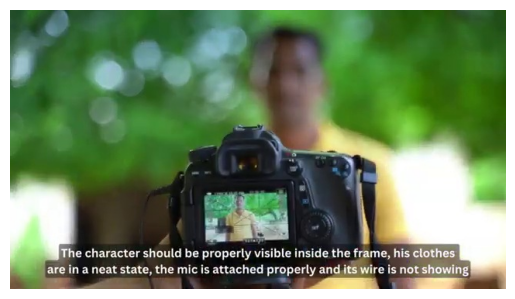

In [ ]:
# viewing 1st result
img = cv2.imread("/content/keyframes/निर्देशक की भूमिका भाग - 3/frame_75.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
search_video("show a scene which has cricket in it")


**Top Results:**
1. [Transcript] The video making team acts like a Cricketer Foutpall team. (30.0s - 35.0s)
    Video: https://www.youtube.com/watch?v=ftDsSB3F5kg

2. [Keyframe] a cricket player is caught by the umpire
    Video: https://www.youtube.com/watch?v=ftDsSB3F5kg
   Frame: /content/keyframes/निर्देशक की भूमिका भाग - 1/frame_40.jpg

3. [Keyframe] a picture of a field with the words in hindi
    Video: https://www.youtube.com/watch?v=MspNdsh0QcM
   Frame: /content/keyframes/स्टोरीबोर्ड का निर्माण भाग - 1/frame_150.jpg

4. [Keyframe] a green field with the words ' in hindi '
    Video: https://www.youtube.com/watch?v=MspNdsh0QcM
   Frame: /content/keyframes/स्टोरीबोर्ड का निर्माण भाग - 1/frame_155.jpg

5. [Transcript] The story of Dhan Rahe should be written in this way, that the viewers should also remain in it. (97.0s - 102.0s)
    Video: https://www.youtube.com/watch?v=MspNdsh0QcM



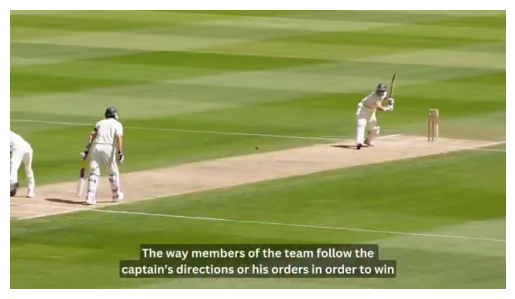

In [ ]:
# viewing 1st result
img = cv2.imread("/content/keyframes/निर्देशक की भूमिका भाग - 1/frame_40.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
search_video("Show a scene where people are sitting under a tree")


**Top Results:**
1. [Keyframe] a group of people sitting under a tree
    Video: https://www.youtube.com/watch?v=kKFrbhZGNNI
   Frame: /content/keyframes/निर्देशक की भूमिका भाग - 2/frame_100.jpg

2. [Keyframe] a group of people standing under a tree
    Video: https://www.youtube.com/watch?v=ftDsSB3F5kg
   Frame: /content/keyframes/निर्देशक की भूमिका भाग - 1/frame_185.jpg

3. [Keyframe] a man and woman standing under a tree
    Video: https://www.youtube.com/watch?v=ftDsSB3F5kg
   Frame: /content/keyframes/निर्देशक की भूमिका भाग - 1/frame_180.jpg

4. [Keyframe] a man and woman standing under a tree
    Video: https://www.youtube.com/watch?v=ftDsSB3F5kg
   Frame: /content/keyframes/निर्देशक की भूमिका भाग - 1/frame_200.jpg

5. [Keyframe] a man standing under a tree with a camera
    Video: https://www.youtube.com/watch?v=kKFrbhZGNNI
   Frame: /content/keyframes/निर्देशक की भूमिका भाग - 2/frame_105.jpg



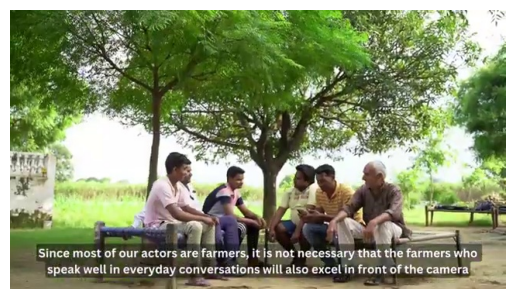

In [ ]:
# viewing 1st result
img = cv2.imread("/content/keyframes/निर्देशक की भूमिका भाग - 2/frame_100.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")
plt.show()